# Классификация комментариев в интернет-магазине

Интернет-магазин запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 
**Задача:** Обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings("ignore")

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
df.describe()

,Unnamed: 0,toxic
count,159292.000000,159292.000000
mean,79725.697242,0.101612
std,46028.837471,0.302139
min,0.000000,0.000000
25%,39872.750000,0.000000
50%,79721.500000,0.000000
75%,119573.250000,0.000000
max,159450.000000,1.000000


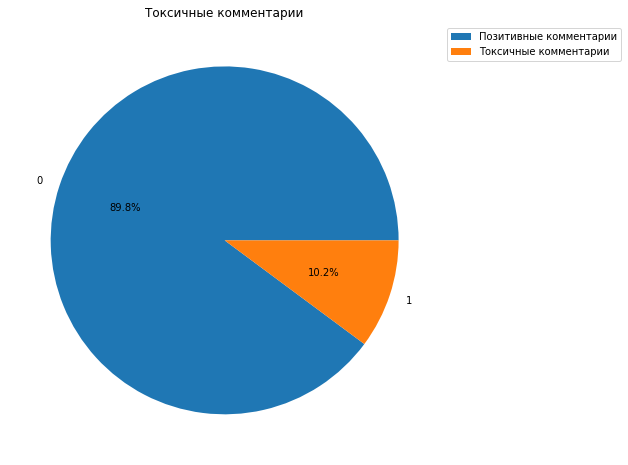

In [4]:
df_tox = df.groupby('toxic').size()
df_tox.plot(kind='pie', autopct='%1.1f%%',  subplots=True, figsize=(8, 8))
plt.title('Токсичные комментарии')
plt.ylabel('')
plt.legend(['Позитивные комментарии','Токсичные комментарии'],loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.show()

### Предобработка

Проверим данные на пропуски и дубликаты.

In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

Данные выглядят хорошо: типы столбцов верные, пропусков и дубликатов нет. Удалим столбец Unnamed: 0 - он не будет влиять на обучение моделей

In [7]:
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Таким образом, в ходе предобработки:
- Пропусков и дубликатов не оказалось
- Удален столбец Unnamed: 0

### Подготовка данных к обучению

In [8]:
# Очистка текста от лишних знаков
def clear(text):
    cleared = re.sub(r'[^a-zA-Z]', ' ', text)
    return " ".join(cleared.split())

In [9]:
# POS-тег
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [10]:
# Лемматизация
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemm_list  = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_list])
    lemm_text = "".join(lemm_list)
    return lemm_text

In [11]:
%%time
learn_df = pd.DataFrame(columns=['text', 'toxic'])

learn_df['toxic'] = df['toxic']
learn_df['text'] = df['text'].apply(lambda x: lemmatize(clear(x)))

learn_df.head()

CPU times: user 17min 47s, sys: 1min 44s, total: 19min 31s
Wall time: 19min 32s


,text,toxic
0,Explanation Why the edits make under my userna...,0
1,D aww He match this background colour I m seem...,0
2,Hey man I m really not try to edit war It s ju...,0
3,More I can t make any real suggestion on impro...,0
4,You sir be my hero Any chance you remember wha...,0


### Разделение на выборки

In [12]:
train, test = train_test_split(learn_df, test_size=0.25, random_state=12345)

features_train = train['text']
features_test = test['text']

target_train = train['toxic']
target_test = test['toxic']

print(features_train.shape)
print(features_test.shape)

(119469,)
(39823,)


### Векторизация признаков

In [13]:
stopwords = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

features_train_tf_idf = count_tf_idf.fit_transform(features_train)
features_test_tf_idf = count_tf_idf.transform(features_test)

## Обучение

In [14]:
f1_scorer = make_scorer(f1_score)

### Логистическая регрессия

In [15]:
%%time

model_log = LogisticRegression(max_iter=1000)

param_log = {'C': [.1, .5, 1],
              'class_weight': ['balanced']}

grid_log = GridSearchCV(estimator=model_log, param_grid=param_log, cv=3, scoring=f1_scorer)
grid_log.fit(features_train_tf_idf, target_train)

print('Лучшие параметры модели логистическая регрессия:', grid_log.best_params_)
print('f1 модели логистическая регрессия:', grid_log.best_score_)

Лучшие параметры модели логистическая регрессия: {'C': 1, 'class_weight': 'balanced'}
f1 модели логистическая регрессия: 0.7409720837636851
CPU times: user 1min 47s, sys: 2min 21s, total: 4min 9s
Wall time: 4min 9s


### LinearSVC

In [16]:
%%time

model_svc = LinearSVC(max_iter=10000)

param_svc = {'C': [.1, .5, 1, 10],
              'class_weight': [None, 'balanced']}

grid_svc = GridSearchCV(estimator=model_svc, param_grid=param_svc, cv=3, scoring=f1_scorer)
grid_svc.fit(features_train_tf_idf, target_train)

print('Лучшие параметры модели LinearSVC:', grid_svc.best_params_)
print('f1 модели LinearSVC:', grid_svc.best_score_)

Лучшие параметры модели LinearSVC: {'C': 1, 'class_weight': None}
f1 модели LinearSVC: 0.7580035838220854
CPU times: user 50.7 s, sys: 255 ms, total: 50.9 s
Wall time: 51 s


### DummyClassifier

In [18]:
model_dum = DummyClassifier(strategy="stratified")
model_dum.fit(features_train, target_train)
predict_dum = model_dum.predict(features_train_tf_idf)
print('f1 модели DummyClassifier:', f1_score(target_train, predict_dum))

f1 модели DummyClassifier: 0.10087229732523048


## Выводы

### Анализ моделей

In [21]:
models = {'Модель':['LogisticRegression', 'LinearSVC','DummyClassifier'],
         'f1':['0.741','0.758','0.101']}

display(pd.DataFrame.from_dict(models))

,Модель,f1
0,LogisticRegression,0.741
1,LinearSVC,0.758
2,DummyClassifier,0.101


Все модели показали результат f1 лучше, чем модель DummyClassifier, что говорит об адекватности всех представленных моделей.
Наилучшей считается модель с минимальным значением f1. Модель с наилучшим результатом - LinearSVC. Проверим эту модель на тестовой выборке.

### Тестирование

Исследуем лучшую модель на тестовой выборке.

In [20]:
model_svc = LinearSVC(max_iter=10000, C=1, class_weight=None)
model_svc.fit(features_train_tf_idf, target_train)
predict_svc = model_svc.predict(features_test_tf_idf)
print('f1 модели LinearSVC на тестовой выбоорке', f1_score(target_test, predict_svc))

f1 модели LinearSVC на тестовой выбоорке 0.7784232365145228


## Вывод

В ходе работы над проектом была проведена предобработка данных:
- Пропусков и дубликатов не оказалось
- Удален столбец Unnamed: 0

Текст данных очищен от лишних знаков и лемматизирован. Проведена векторизация признаков.

Для исслеования использовались следующие модели:
- LogisticRegression 
- LinearSVC 
- DummyClassifier 

Все модели показали на тренировочной выборке результат f1 лучше, чем модель DummyClassifier, что говорит об адекватности всех представленных моделей. Модель с наилучшим результатом f1 - LinearSVC.

f1 моделей на тренировочной выборке:
- LogisticRegression (0.741)
- LinearSVC (0.758)
- DummyClassifier (0.101)

f1 лучшей модели на тестовой выборке:
- LinearSVC (0.778)